# Exploring top known GCFs commonly present across the dataset 

In [1]:
import os
import pandas as pd
import sqlite3
import yaml
import json
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
with open("config.yaml", "r") as f:
    notebook_configuration = yaml.safe_load(f)
notebook_configuration

{'bgcflow_dir': '/datadrive/bgcflow'}

In [3]:
# Write samples.csv table to config directory of qc_strepto_ncbi project
bgcflow_dir = Path(notebook_configuration["bgcflow_dir"])
project_name_1 = "mq_strepto"
processed_dir_1 = bgcflow_dir / "data" / "processed" / project_name_1

# Read output tables from the processed directory
ncbi_meta_table = processed_dir_1 / "tables"/ "df_ncbi_meta.csv"
df_ncbi_meta = pd.read_csv(ncbi_meta_table, index_col= 0)

gtdb_meta_table = processed_dir_1 / "tables"/ "df_gtdb_meta_curated.csv"
df_gtdb_meta = pd.read_csv(gtdb_meta_table, index_col= 0)

seqfu_meta_table = processed_dir_1 / "tables"/ "df_seqfu_stats.csv"
df_seqfu_meta = pd.read_csv(seqfu_meta_table, index_col= 0)

mash_table = processed_dir_1 / "mash"/ "df_mash.csv"
df_mash = pd.read_csv(mash_table, index_col= 0)

df_clusters = pd.read_csv("assets/tables/df_clusters.csv", index_col=0)

filters_table = processed_dir_1 / "tables" / "df_filters.csv"
df_filter_quality = pd.read_csv(filters_table, index_col=0)

antismash_summary_table = processed_dir_1 / "tables" / "df_antismash_7.0.0_summary.csv"
df_antismash_summary = pd.read_csv(antismash_summary_table, index_col=0, low_memory=False)

bgcs_summary_table = processed_dir_1 / "tables" / "df_regions_antismash_7.0.0.csv"
df_bgcs_antismash = pd.read_csv(bgcs_summary_table, index_col=0)

arts_table = processed_dir_1 / "tables" / "df_arts_as-7.0.0.csv"
df_arts = pd.read_csv(arts_table, index_col=0)
df_clusters["Subcluster_label"] = df_clusters.Subcluster_label.fillna("NA")
df_clusters["Cluster_label"] = df_clusters.Cluster_label.fillna("NA")

In [4]:
# Read bigslice results
df_gcf_presence = pd.read_csv(processed_dir_1 / "bigslice" / "cluster_as_7.0.0" / "df_gcf_presence_combined.csv", index_col=0)
df_gcfs_bigslice = pd.read_csv(processed_dir_1 / "bigslice" / "cluster_as_7.0.0" / "df_gcfs_combined.csv",index_col=0) 
df_bgcs_bigslice = pd.read_csv(processed_dir_1 / "bigslice" / "cluster_as_7.0.0" / "df_bgcs_curated_with_combined.csv", index_col=0) 

In [5]:
df_top_gcfs_known = df_gcfs_bigslice[df_gcfs_bigslice.known == "Known"].iloc[:20,:]
df_top_gcfs_known.bgc_count.sum()

19763.0

In [6]:
phylogroup_counts = dict()
for phylogroup in sorted(df_clusters.Cluster_label.unique()):
    df_top_gcfs_known[phylogroup] = 0
    df_top_gcfs_known[phylogroup + "_percent"] = 0
    phylogroup_counts[phylogroup] = df_clusters.Cluster_label.value_counts()[phylogroup] 
    
for gcf_id in df_top_gcfs_known.index:
    genome_id_list = df_bgcs_bigslice[df_bgcs_bigslice.gcf_combined_id == gcf_id].genome_id.unique()
    df_phylogroup_dist = df_clusters.loc[genome_id_list, :]["Cluster_label"].value_counts()
    for phylogroup in df_phylogroup_dist.index:
        df_top_gcfs_known.loc[gcf_id, phylogroup] = df_phylogroup_dist[phylogroup]
        df_top_gcfs_known.loc[gcf_id, f"{phylogroup}_percent"] = df_phylogroup_dist[phylogroup] * 100/ phylogroup_counts[phylogroup] 

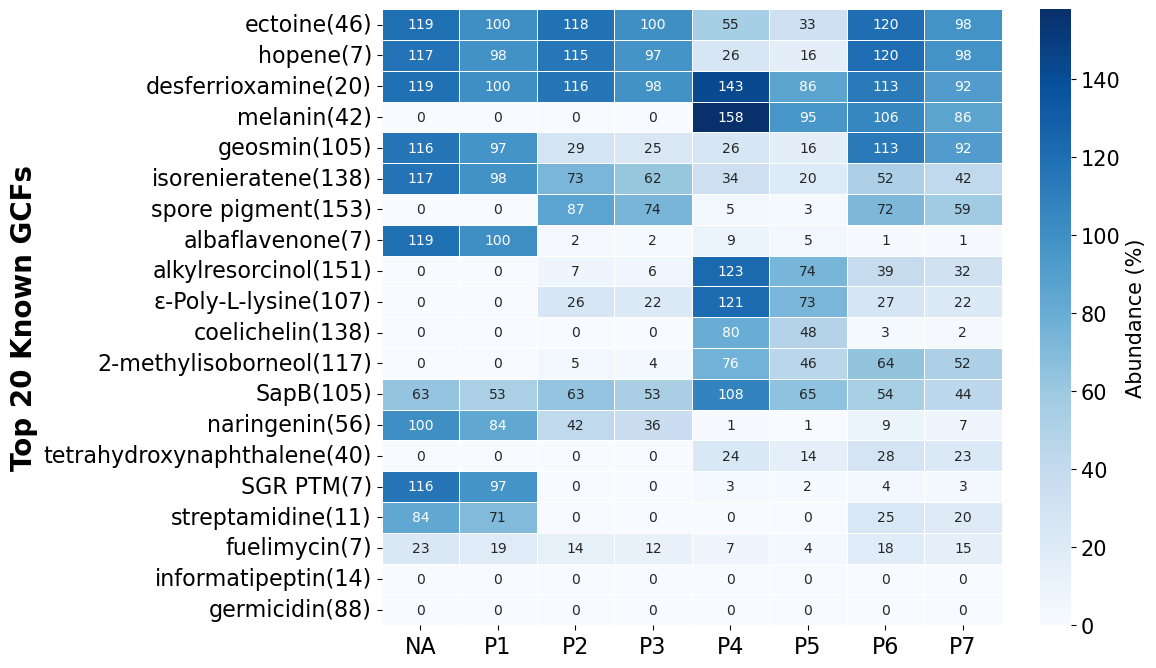

In [7]:
data = df_top_gcfs_known.iloc[:,-8:]
data.index = [df_top_gcfs_known.loc[gcf_id, "gcf_combined_name"] + "("+ str(df_top_gcfs_known.loc[gcf_id, "bigslice_gcf_count"]) + ")" for gcf_id in df_top_gcfs_known.index.tolist()] 
data.columns = sorted(df_clusters.Cluster_label.unique())
# Create a heatmap with specified figure size
plt.figure(figsize=(10, 8))

# Generate a heatmap
ax = sns.heatmap(data, linewidths=.5, cmap='Blues', 
                 annot=True, fmt=".0f",
              cbar_kws={'label': 'Abundance (%)', 'orientation': 'vertical'})

# Get the color bar
cbar = ax.collections[0].colorbar
cbar.set_label('Abundance (%)', size=15)
for t in cbar.ax.yaxis.get_ticklabels():
    t.set_fontsize(15)

# Customize fonts
# plt.title('Top 20 Known GCFs', fontdict={'fontsize':20, 'fontweight':'bold'})
# plt.xlabel('X Axis Label', fontsize=15, fontweight='bold')
plt.ylabel('Top 20 Known GCFs', fontsize=20, fontweight='bold')

# Customize tick labels font
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16, fontweight='normal')
ax.set_yticklabels(ax.get_yticklabels(), fontsize=16, fontweight='normal')

# Save the plot
plt.savefig("assets/figures/Figure_4/Figure_4a.svg", bbox_inches="tight")
plt.savefig("assets/figures/Figure_4/Figure_4a.png", bbox_inches="tight")

# Display the plot
plt.show()

# Assess diversity per cluster type

In [8]:
df_gcfs_bigslice_known = df_gcfs_bigslice[df_gcfs_bigslice.known == "Known"]
df_bgcs = pd.concat([df_bgcs_antismash, df_bgcs_bigslice], axis=1)
df_bgcs_known = df_bgcs[df_bgcs.gcf_combined_id.isin(df_gcfs_bigslice_known.index)]
df_bgcs_unknown = df_bgcs[~df_bgcs.gcf_combined_id.isin(df_gcfs_bigslice_known.index)]

In [9]:
for bgc_id in df_bgcs.index:
    bgc_type = df_bgcs.loc[bgc_id, "product"]
    bgc_list = bgc_type[1:-1].split(",")
    bgc_list_updated = []
    for bgc_type_cntr in bgc_list:
        bgc_list_updated.append(bgc_type_cntr.strip()[1:-1])
    bgc_type_updated = ".".join(sorted(bgc_list_updated))
    df_bgcs.loc[bgc_id, "bgc_type"] = bgc_type_updated

In [10]:
top_bgc_types = df_bgcs.bgc_type.unique()
df_bgc_types = pd.DataFrame(0, index=top_bgc_types, columns=["bgcs", "Total", "GCFs_known", "GCFs_known_combined", "GCFs_unknown"])

for bgc_type in top_bgc_types:
    df_selected = df_bgcs[df_bgcs["bgc_type"] == bgc_type]
    df_selected_known = df_selected[df_selected.gcf_combined_id.isin(df_gcfs_bigslice_known.index)]
    df_selected_unknown =  df_selected[~df_selected.gcf_combined_id.isin(df_gcfs_bigslice_known.index)]

    df_bgc_types.loc[bgc_type, "bgcs"] = df_selected.shape[0]
    df_bgc_types.loc[bgc_type, "Total"] = len(df_selected.gcf_id.unique())
    df_bgc_types.loc[bgc_type, "GCFs_known"] = len(df_selected_known.gcf_id.unique())
    df_bgc_types.loc[bgc_type, "GCFs_known_combined"] = len(df_selected_known.gcf_combined_id.unique())
    df_bgc_types.loc[bgc_type, "GCFs_unknown"] = len(df_selected_unknown.gcf_id.unique())


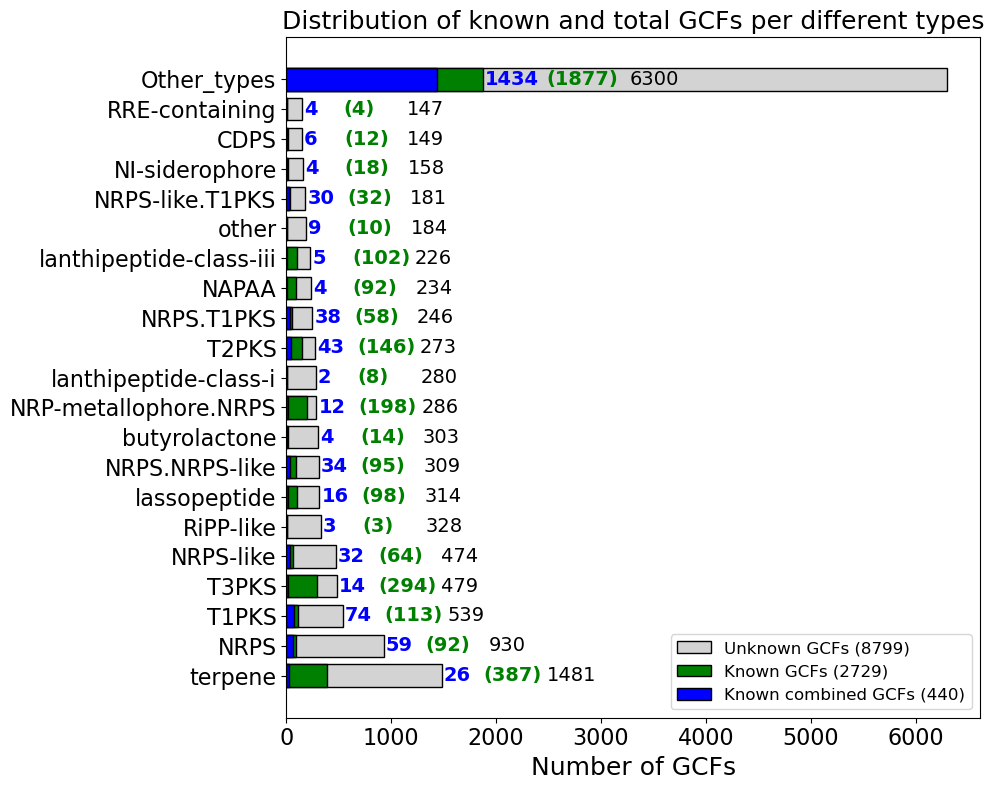

In [12]:
df = df_bgc_types.sort_values(by="Total", ascending=False)[:20]
df.loc["Other_types", :] = df_bgc_types.sort_values(by="Total", ascending=False)[20:].sum()
# Font sizes
title_fontsize = 18
label_fontsize = 16
annotation_fontsize = 14
percent_fontsize = 14

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plotting the total_bgcs as background bars
bars_total = ax.barh(df.index, df['Total'], color='lightgrey', edgecolor='black', label='Total GCFs', height=0.75)

# # Plotting known_bgcs on top of total
# bars_unknown = ax.barh(df.index, df['GCFs_unknown'], color='lightgrey', edgecolor='black', label='Unknown BGCs', height=0.75)

# Plotting known_bgcs on top of total
bars_known = ax.barh(df.index, df['GCFs_known'], color='green', edgecolor='black', label='Known GCFs', height=0.75)

# Plotting known_bgcs on top of total
bars_known_combined = ax.barh(df.index, df['GCFs_known_combined'], color='blue', edgecolor='black', label='Unknown BGCs', height=0.75)

# # Annotating bars
for i, (bar_total, bars_known) in enumerate(zip(bars_total, bars_known)):
    width_total = bar_total.get_width()
    width_similar = bars_known.get_width()

    if width_total > 2000:
        ax.text(width_similar + 1400, bar_total.get_y() + bar_total.get_height()/2, 
                f'{int(df["Total"].iloc[i])}', va='center', ha='left', fontsize=annotation_fontsize) 
        ax.text(width_similar + 20, bar_total.get_y() + bar_total.get_height()/2,  
                f'{df["GCFs_known_combined"].iloc[i]:.0f}', va='center', ha='left', color="Blue", fontweight='bold', fontsize=percent_fontsize) 
        ax.text(width_similar + 600, bar_total.get_y() + bar_total.get_height()/2,  
                f'({df["GCFs_known"].iloc[i]:.0f})', va='center', ha='left', color="Green", fontweight='bold', fontsize=percent_fontsize)
    else:
        ax.text(width_total + 1000, bar_total.get_y() + bar_total.get_height()/2, 
                f'{int(df["Total"].iloc[i])}', va='center', ha='left', fontsize=annotation_fontsize)
        ax.text(width_total + 20, bar_total.get_y() + bar_total.get_height()/2,  
                f'{df["GCFs_known_combined"].iloc[i]:.0f}', va='center', ha='left', fontweight='bold', color="Blue", fontsize=percent_fontsize)
        ax.text(width_total + 400, bar_total.get_y() + bar_total.get_height()/2,  
                f'({df["GCFs_known"].iloc[i]:.0f})', va='center', ha='left', color="Green", fontweight='bold', fontsize=percent_fontsize)
ax.set_xlabel('Number of GCFs',fontsize=title_fontsize)
ax.set_title('Distribution of known and total GCFs per different types', fontsize=title_fontsize)
ax.legend([f"Unknown GCFs ({df_gcfs_bigslice.known.value_counts()['Unknown']})", 
           f"Known GCFs ({df_gcfs_bigslice_known.bigslice_gcf_count.sum()})", 
           f"Known combined GCFs ({int(df_gcfs_bigslice_known.shape[0])})"], fontsize=12)

# Setting font size for tick labels
ax.tick_params(axis='both', which='major', labelsize=label_fontsize)
plt.tight_layout()
plt.savefig("assets/figures/Figure_4/a.png")
plt.savefig("assets/figures/Figure_4/a.svg")
plt.show()

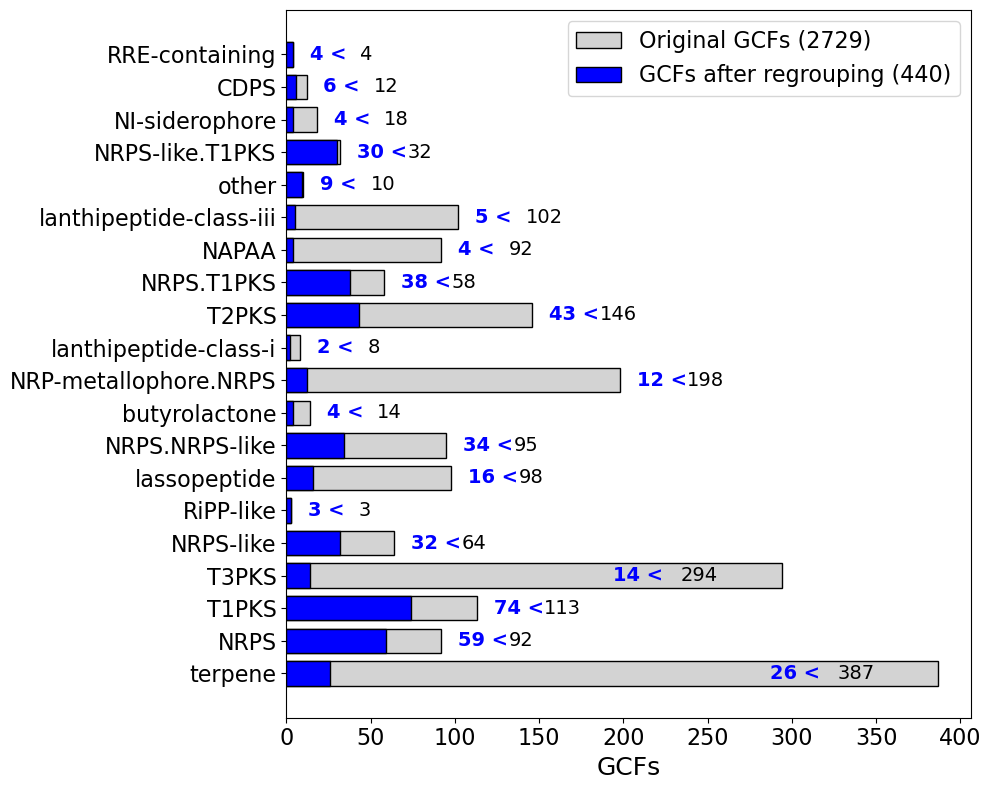

In [38]:
df = df_bgc_types.sort_values(by="Total", ascending=False)[:20]

# Font sizes
title_fontsize = 18
label_fontsize = 16
annotation_fontsize = 14
percent_fontsize = 14

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

# # Plotting the total_bgcs as background bars
# bars_total = ax.barh(df.index, df['Total'], color='lightgrey', edgecolor='black', label='Total GCFs', height=0.75)

# # Plotting known_bgcs on top of total
# bars_unknown = ax.barh(df.index, df['GCFs_unknown'], color='lightgrey', edgecolor='black', label='Unknown BGCs', height=0.75)

# Plotting known_bgcs on top of total
bars_known = ax.barh(df.index, df['GCFs_known'], color='lightgrey', edgecolor='black', label='Known GCFs', height=0.75)

# Plotting known_bgcs on top of total
bars_known_combined = ax.barh(df.index, df['GCFs_known_combined'], color='blue', edgecolor='black', label='Unknown BGCs', height=0.75)

# # Annotating bars
for i, (bars_known, bars_known_combined) in enumerate(zip(bars_known, bars_known_combined)):
    width_orig = bars_known.get_width()
    width_merged = bars_known_combined.get_width()

    if width_orig > 250:
        ax.text(width_orig - 100, bars_known.get_y() + bars_known.get_height()/2,  
                f'{df["GCFs_known_combined"].iloc[i]:.0f} <', va='center', ha='left', fontweight='bold', color="Blue", fontsize=percent_fontsize)
        ax.text(width_orig - 60, bars_known.get_y() + bars_known.get_height()/2, 
                f'{int(df["GCFs_known"].iloc[i])}', va='center', ha='left', fontsize=annotation_fontsize)
        # ax.text(width_similar + 600, bar_total.get_y() + bar_total.get_height()/2,  
        #         f'({df["GCFs_known"].iloc[i]:.0f})', va='center', ha='left', color="Green", fontweight='bold', fontsize=percent_fontsize)
    else:
        ax.text(width_orig+10, bars_known.get_y() + bars_known.get_height()/2,  
                f'{df["GCFs_known_combined"].iloc[i]:.0f} <', va='center', ha='left', fontweight='bold', color="Blue", fontsize=percent_fontsize)
        ax.text(width_orig + 40, bars_known.get_y() + bars_known.get_height()/2, 
                f'{int(df["GCFs_known"].iloc[i])}', va='center', ha='left', fontsize=annotation_fontsize)
        
        # ax.text(width_total + 400, bar_total.get_y() + bar_total.get_height()/2,  
        #         f'({df["GCFs_known"].iloc[i]:.0f})', va='center', ha='left', color="Green", fontweight='bold', fontsize=percent_fontsize)
ax.set_xlabel('GCFs',fontsize=title_fontsize)
# ax.set_title('Distribution of known and total GCFs per different types', fontsize=title_fontsize)
ax.legend([f"Original GCFs ({df_gcfs_bigslice_known.bigslice_gcf_count.sum()})", 
           f"GCFs after regrouping ({int(df_gcfs_bigslice_known.shape[0])})"], fontsize=16)

# Setting font size for tick labels
ax.tick_params(axis='both', which='major', labelsize=label_fontsize)
plt.tight_layout()
plt.savefig("assets/figures/Figure_4/a.png")
plt.savefig("assets/figures/Figure_4/a.svg")
plt.show()

In [179]:
df["known_percent"] = df["GCFs_known"] * 100/ df["Total"] 
df.sort_values(by="known_percent", ascending=False)
# df.sort_values(by="bgcs", ascending=False)

,bgcs,Total,GCFs_known,GCFs_known_combined,GCFs_unknown,known_percent
NRP-metallophore.NRPS,1219.0,286.0,198.0,12.0,88.0,69.230769
T3PKS,2562.0,479.0,294.0,14.0,185.0,61.377871
T2PKS,1536.0,273.0,146.0,43.0,127.0,53.479853
lanthipeptide-class-iii,1181.0,226.0,102.0,5.0,124.0,45.132743
NAPAA,1387.0,234.0,92.0,4.0,142.0,39.316239
lassopeptide,1167.0,314.0,98.0,16.0,216.0,31.210191
NRPS.NRPS-like,906.0,309.0,95.0,34.0,214.0,30.744337
Other_types,25332.0,6300.0,1877.0,1434.0,4423.0,29.793651
terpene,11095.0,1481.0,387.0,26.0,1094.0,26.130993
NRPS.T1PKS,1536.0,246.0,58.0,38.0,188.0,23.577236


In [126]:
int(df_gcfs_bigslice.known.value_counts()["Unknown"])

8799

In [131]:
df_gcfs_bigslice.known.value_counts()['Unknown']

8799

In [7]:
df_top_gcfs_unknown = df_gcfs_bigslice[df_gcfs_bigslice.known== "Unknown"][:50]
for gcf_id in df_top_gcfs_unknown.index:
    df_bgcs_selected = df_bgcs_antismash.loc[df_bgcs_bigslice[df_bgcs_bigslice.gcf_combined_id == str(gcf_id)].index,:]
    print(gcf_id, ", size:", df_bgcs_selected.shape[0])
    if len(df_bgcs_selected.most_similar_known_cluster_description.value_counts()) > 0:
        print(df_bgcs_selected.most_similar_known_cluster_description.value_counts().index[0], df_bgcs_selected.most_similar_known_cluster_description.value_counts()[0])

597 , size: 966
schizokinen 392
157 , size: 927
schizokinen 420
105 , size: 442
informatipeptin 442
798 , size: 413
steffimycin D 412
1145 , size: 267
grincamycin 184
1116 , size: 245
grincamycin 47
267 , size: 230
carbapenem MM4550 19
2834 , size: 227
cyclothiazomycin 32
4220 , size: 184
stenothricin 182
8113 , size: 153
A-47934 130
7661 , size: 140
hopene 138
2280 , size: 125
fluostatins M-Q 113
20 , size: 124
hexacosalactone A 123
678 , size: 111
coelimycin P1 111
1476 , size: 111
griselimycin 12
641 , size: 109
hexacosalactone A 108
819 , size: 104
4787 , size: 103
showdomycin 103
626 , size: 102
peucechelin 102
1520 , size: 99
neocarzinostatin 7
1328 , size: 96
monensin 88
180 , size: 96
istamycin 94
363 , size: 95
griselimycin 29
8468 , size: 95
foxicin A/foxicin B/foxicin C/foxicin 92
8983 , size: 93
hexacosalactone A 92
6172 , size: 92
dudomycin A 92
9546 , size: 91
valinomycin/montanastatin 86
3241 , size: 89
coelimycin P1 89
7329 , size: 87
depsibosamycin B/depsibosamycin C/d

In [51]:
df_top_known_gcf_presence = df_gcf_presence[df_top_gcfs_known.index]
df_top_known_gcf_presence.columns = df_top_gcfs_known.gcf_combined_name
df_top_known_gcf_presence.to_csv("/datadrive/bgcflow/data/processed/mq_strepto/iTOL/df_top_known_gcf_presence.csv")

In [60]:
for gcf_id in df_top_gcfs_known.index:
    gcf_name = df_top_gcfs_known.loc[gcf_id, "gcf_combined_name"]
    df_bgcs_selected = df_bgcs_bigslice[df_bgcs_bigslice.gcf_combined_id == gcf_id]
    
    df_samples = df_bgcs_selected.copy()
    
    report_dir = bgcflow_dir / f"data/processed/{project_name_1}"
    mapping_dir = report_dir / "log_changes/7.0.0/"
    antismash_dir = report_dir / "antismash/7.0.0/"
    
    for i in df_samples.index:
        genome_id = df_samples.loc[i, "genome_id"]
        mapping_dict = mapping_dir / f"{genome_id}-change_log.json"
        with open(mapping_dict, "r") as f:
            mapping_dict = json.load(f)
        for item in mapping_dict[genome_id].values():
            if Path(item['symlink_path']).stem == i:
                gbk_file = Path(item['target_path']).name
                gbk_file = antismash_dir / genome_id / gbk_file
                assert gbk_file.is_file()
                df_samples.loc[i, 'gbk_path'] = gbk_file.resolve()
                df_samples.loc[i, 'record_id'] = item['record_id']
                df_samples.loc[i, 'original_id'] = item['original_id']
    df_samples['source'] = "bgcflow"

    outfile = bgcflow_dir / f"config/{gcf_name}/samples.csv"
    outfile.parent.mkdir(parents=True, exist_ok=True)
    df_samples.to_csv(outfile)

In [75]:
config_file = bgcflow_dir / f".examples/lanthipeptide_lactobacillus/project_config.yaml"
with open(config_file, "r") as f:
    project_config = yaml.safe_load(f)

for gcf_id in df_top_gcfs_known.index:
    gcf_name = df_top_gcfs_known.loc[gcf_id, "gcf_combined_name"]
    
    project_config['name'] = gcf_name
    project_config['description'] = f'A selection of BGCs from known combined GCF {gcf_name}'
    
    project_config['sample_table'] = 'samples.csv'
    project_config['rules'] = {'bigslice': False,
      'bigscape': True,
      'query-bigslice': False,
      'clinker': False,
      'interproscan': False,
      'mmseqs2': False}
    
    config_outfile = bgcflow_dir / f"config/{gcf_name}/project_config.yaml"
    with open(config_outfile, 'w') as file:
        yaml.safe_dump(project_config, file)

# Isorenieratene BiGSCAPE results

In [10]:
df_selected_bgcs = pd.read_csv("/datadrive/bgcflow/config/isorenieratene/samples.csv", index_col=0)
df_selected_bgcs_bigscape = pd.read_csv("/datadrive/bgcflow/data/interim/bigscape/no_mibig_isorenieratene_antismash_7.0.0/network_files/2023-09-27_13-30-20_glocal_isorenieratene_antismash_7.0.0/Network_Annotations_Full.tsv", index_col=0, sep="\t")
df_selected_gcfs_bigscape = pd.read_csv("/datadrive/bgcflow/data/interim/bigscape/no_mibig_isorenieratene_antismash_7.0.0/network_files/2023-09-27_13-30-20_glocal_isorenieratene_antismash_7.0.0/mix/mix_clustering_c0.30.tsv", index_col=0, sep="\t")
df_selected_bgcs_antismash = df_bgcs_antismash.loc[df_selected_bgcs.index, :]

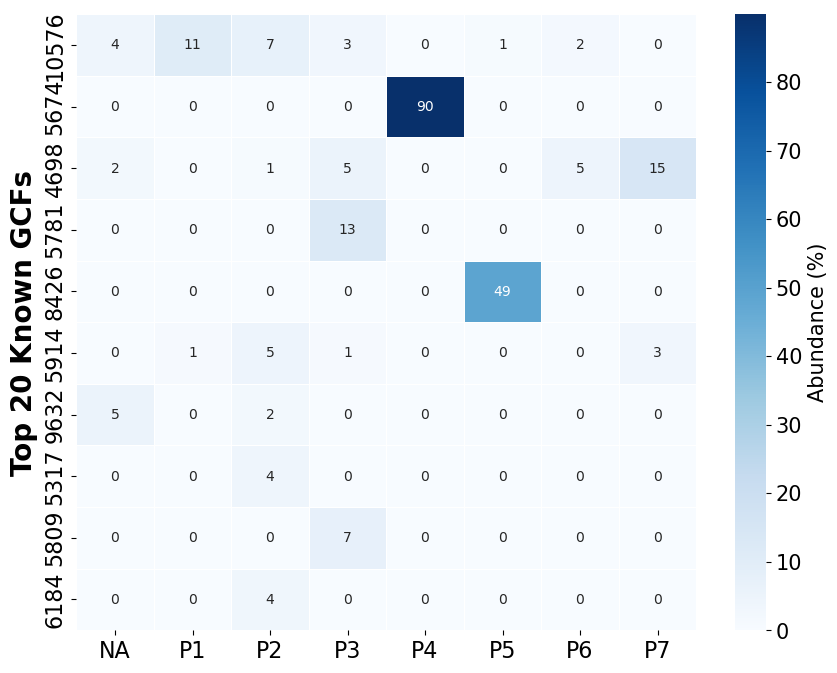

In [11]:
df_top_selected_gcfs = pd.DataFrame(index=df_selected_bgcs.gcf_id.value_counts().index[:10], columns=sorted(df_clusters.Cluster_label.unique()))
phylogroup_counts = dict()
for phylogroup in sorted(df_clusters.Cluster_label.unique()):
    df_top_selected_gcfs[phylogroup] = 0
    df_top_selected_gcfs[phylogroup + "_percent"] = 0
    phylogroup_counts[phylogroup] = df_clusters.Cluster_label.value_counts()[phylogroup] 
    
for gcf_id in df_top_selected_gcfs.index:
    genome_id_list = df_bgcs_bigslice[df_bgcs_bigslice.gcf_id == gcf_id].genome_id.unique()
    df_phylogroup_dist = df_clusters.loc[genome_id_list, :]["Cluster_label"].value_counts()
    for phylogroup in df_phylogroup_dist.index:
        df_top_selected_gcfs.loc[gcf_id, phylogroup] = df_phylogroup_dist[phylogroup]
        df_top_selected_gcfs.loc[gcf_id, f"{phylogroup}_percent"] = df_phylogroup_dist[phylogroup] * 100/ phylogroup_counts[phylogroup] 

data = df_top_selected_gcfs.iloc[:,-8:]
data.columns = sorted(df_clusters.Cluster_label.unique())
# Create a heatmap with specified figure size
plt.figure(figsize=(10, 8))

# Generate a heatmap
ax = sns.heatmap(data, linewidths=.5, cmap='Blues', 
                 annot=True, fmt=".0f",
              cbar_kws={'label': 'Abundance (%)', 'orientation': 'vertical'})

# Get the color bar
cbar = ax.collections[0].colorbar
cbar.set_label('Abundance (%)', size=15)
for t in cbar.ax.yaxis.get_ticklabels():
    t.set_fontsize(15)

# Customize fonts
# plt.title('Top 20 Known GCFs', fontdict={'fontsize':20, 'fontweight':'bold'})
# plt.xlabel('X Axis Label', fontsize=15, fontweight='bold')
plt.ylabel('Top 20 Known GCFs', fontsize=20, fontweight='bold')

# Customize tick labels font
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16, fontweight='normal')
ax.set_yticklabels(ax.get_yticklabels(), fontsize=16, fontweight='normal')

# Save the plot
# plt.savefig("assets/figures/Figure_4/Figure_4a.svg", bbox_inches="tight")
# plt.savefig("assets/figures/Figure_4/Figure_4a.png", bbox_inches="tight")

# Display the plot
plt.show()

# Spore pigment BiGSCAPE results

In [143]:
df_selected_bgcs = pd.read_csv("/datadrive/bgcflow/config/spore_pigment/samples.csv", index_col=0)
df_selected_bgcs_bigscape = pd.read_csv("/datadrive/bgcflow/data/interim/bigscape/no_mibig_spore_pigment_antismash_7.0.0/network_files/2023-09-27_13-54-08_glocal_spore_pigment_antismash_7.0.0/7_13-30-20_glocal_isorenieratene_antismash_7.0.0/Network_Annotations_Full.tsv", index_col=0, sep="\t")
df_selected_gcfs_bigscape = pd.read_csv("/datadrive/bgcflow/data/interim/bigscape/no_mibig_isorenieratene_antismash_7.0.0/network_files/2023-09-27_13-30-20_glocal_isorenieratene_antismash_7.0.0/mix/mix_clustering_c0.30.tsv", index_col=0, sep="\t")
df_selected_bgcs_antismash = df_bgcs_antismash.loc[df_selected_bgcs.index, :]

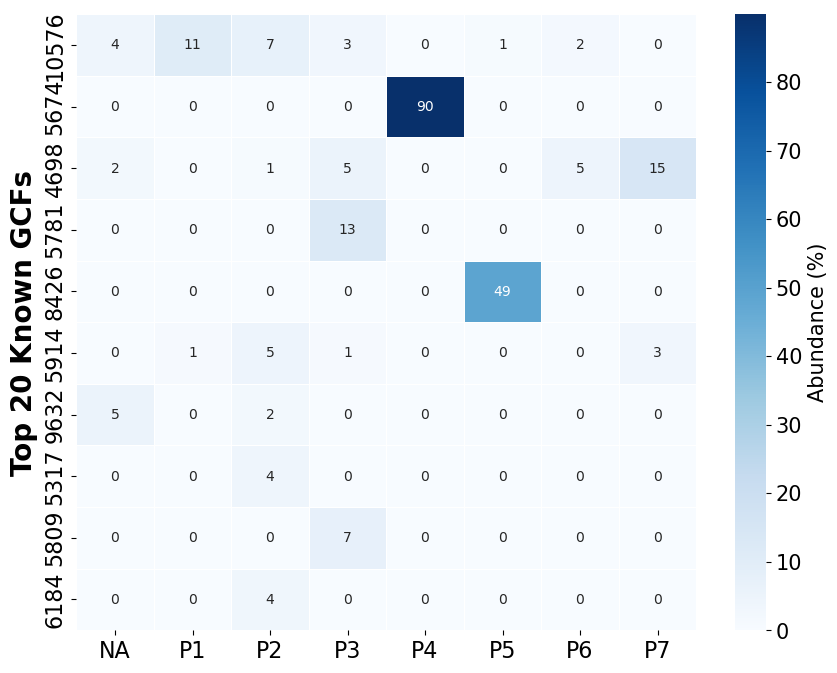

In [167]:
df_top_selected_gcfs = pd.DataFrame(index=df_selected_bgcs.gcf_id.value_counts().index[:10], columns=sorted(df_clusters.Cluster_label.unique()))
phylogroup_counts = dict()
for phylogroup in sorted(df_clusters.Cluster_label.unique()):
    df_top_selected_gcfs[phylogroup] = 0
    df_top_selected_gcfs[phylogroup + "_percent"] = 0
    phylogroup_counts[phylogroup] = df_clusters.Cluster_label.value_counts()[phylogroup] 
    
for gcf_id in df_top_selected_gcfs.index:
    genome_id_list = df_bgcs_bigslice[df_bgcs_bigslice.gcf_id == gcf_id].genome_id.unique()
    df_phylogroup_dist = df_clusters.loc[genome_id_list, :]["Cluster_label"].value_counts()
    for phylogroup in df_phylogroup_dist.index:
        df_top_selected_gcfs.loc[gcf_id, phylogroup] = df_phylogroup_dist[phylogroup]
        df_top_selected_gcfs.loc[gcf_id, f"{phylogroup}_percent"] = df_phylogroup_dist[phylogroup] * 100/ phylogroup_counts[phylogroup] 

data = df_top_selected_gcfs.iloc[:,-8:]
data.columns = sorted(df_clusters.Cluster_label.unique())
# Create a heatmap with specified figure size
plt.figure(figsize=(10, 8))

# Generate a heatmap
ax = sns.heatmap(data, linewidths=.5, cmap='Blues', 
                 annot=True, fmt=".0f",
              cbar_kws={'label': 'Abundance (%)', 'orientation': 'vertical'})

# Get the color bar
cbar = ax.collections[0].colorbar
cbar.set_label('Abundance (%)', size=15)
for t in cbar.ax.yaxis.get_ticklabels():
    t.set_fontsize(15)

# Customize fonts
# plt.title('Top 20 Known GCFs', fontdict={'fontsize':20, 'fontweight':'bold'})
# plt.xlabel('X Axis Label', fontsize=15, fontweight='bold')
plt.ylabel('Top 20 Known GCFs', fontsize=20, fontweight='bold')

# Customize tick labels font
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16, fontweight='normal')
ax.set_yticklabels(ax.get_yticklabels(), fontsize=16, fontweight='normal')

# Save the plot
# plt.savefig("assets/figures/Figure_4/Figure_4a.svg", bbox_inches="tight")
# plt.savefig("assets/figures/Figure_4/Figure_4a.png", bbox_inches="tight")

# Display the plot
plt.show()